In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import os
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import find_dotenv, load_dotenv
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import (
    ShuffleSplit,
    cross_val_predict,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

from src.visualization.visualize import crossvalidate_pipeline_scores, plot_scores

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123


In [2]:

df_iphone = pd.read_csv(os.path.join("data", "processed", "iphone.csv"))
df_galaxy = pd.read_csv(os.path.join("data", "processed", "galaxy.csv"))


In [3]:

iphone_target = "iphonesentiment"
galaxy_target = "galaxysentiment"

X_train_iphone, X_test_iphone, y_train_iphone, y_test_iphone = train_test_split(
    df_iphone.drop(columns=iphone_target),
    df_iphone[iphone_target],
    test_size=0.2,
    random_state=random_state,
)

X_train_galaxy, X_test_galaxy, y_train_galaxy, y_test_galaxy = train_test_split(
    df_galaxy.drop(columns=galaxy_target),
    df_galaxy[galaxy_target],
    test_size=0.2,
    random_state=random_state,
)


 # Models and Pipelines

 * We test the following models:
   * GLMNET
   * SVM
   * KNN
   * Gradient Boosting
   * Random Forest
   * Decision Trees
   * Extra Trees models

 * Preprocessing steps in the pipelines are following:
   * Dropping features with no variance (already done for the dataset,
 but not within each fold)
   * Scaling with RobustScaler as there are both outliers
 and the values don't follow a Gaussian distribution

In [4]:

# The data are clearly not normally distributed and there are outliers
# so we use RobustScaler instead of StandardScaler
pipelines = {
    "glmnet": make_pipeline(VarianceThreshold(), RobustScaler(), ElasticNet()),
    "svm": make_pipeline(VarianceThreshold(), RobustScaler(), SVR(gamma="auto")),
    "knn": make_pipeline(VarianceThreshold(), RobustScaler(), KNeighborsRegressor()),
    "gradientboosting": make_pipeline(
        VarianceThreshold(), RobustScaler(), GradientBoostingRegressor()
    ),
    "randomforerst": make_pipeline(
        VarianceThreshold(), RobustScaler(), RandomForestRegressor(n_estimators=100)
    ),
    "decisiontrees": make_pipeline(
        VarianceThreshold(), RobustScaler(), DecisionTreeRegressor()
    ),
    "extratrees": make_pipeline(
        VarianceThreshold(), RobustScaler(), ExtraTreeRegressor()
    ),
}


 # Comparing the Models with Iphone Data

 * SVM and KNN are computationally expensive to train, but KNN only for metric calculation
 * GLMNET is significantly worse than any other model

Crossvalidating glmnet
Crossvalidating svm
Crossvalidating knn
Crossvalidating gradientboosting
Crossvalidating randomforerst
Crossvalidating decisiontrees
Crossvalidating extratrees
fit_time
score_time
test_r2
test_neg_mean_absolute_error
test_neg_mean_squared_error


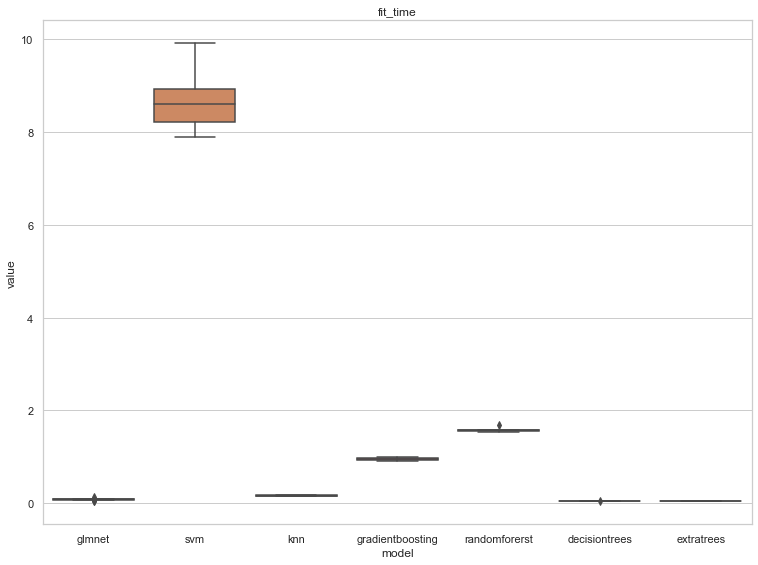

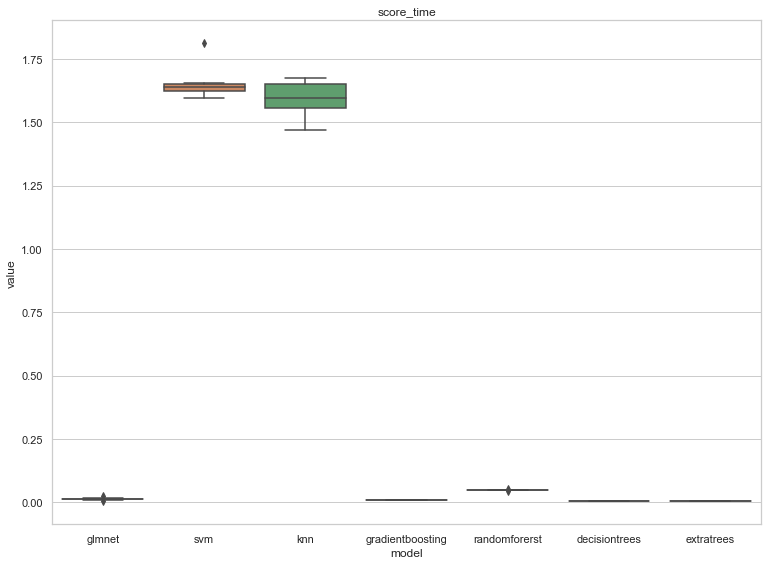

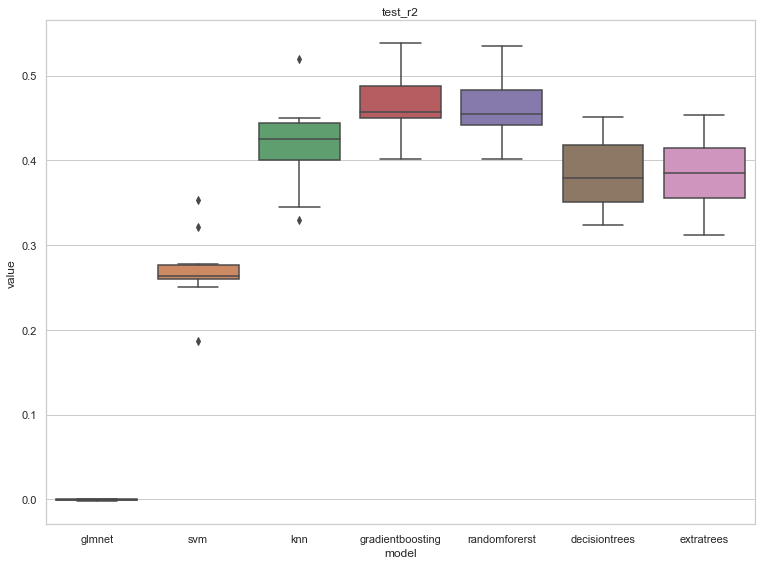

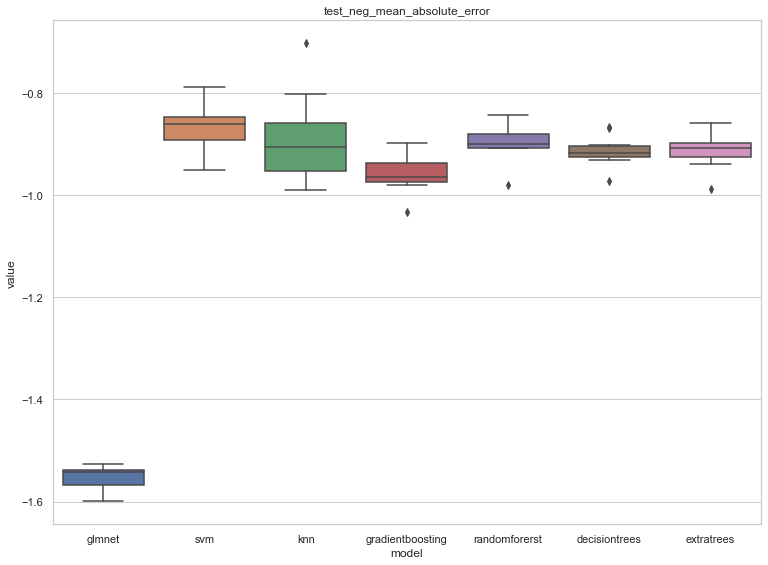

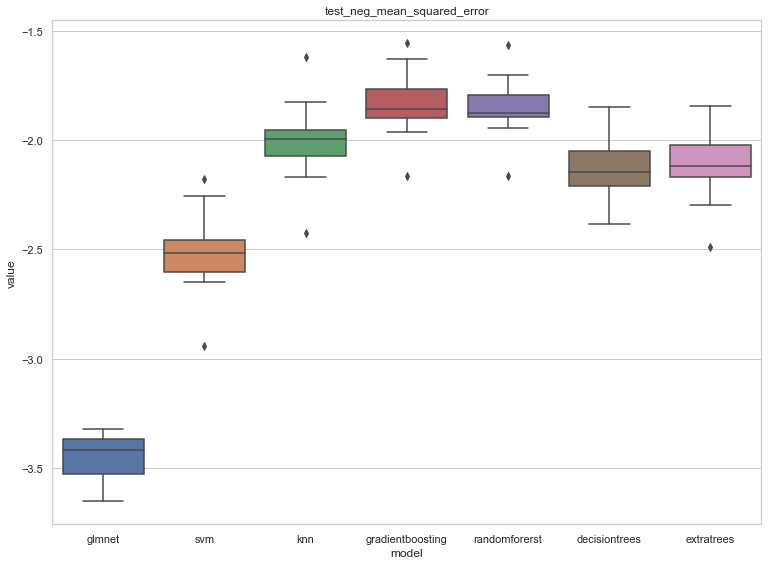

In [5]:

scores_iphone = crossvalidate_pipeline_scores(
    X=X_train_iphone,
    y=y_train_iphone,
    pipelines=pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores_iphone, show_costs=True)


 # Comparing the Models with Galaxy Data

 * GLMNET is significantly worse than any other model

Crossvalidating glmnet
Crossvalidating svm
Crossvalidating knn
Crossvalidating gradientboosting
Crossvalidating randomforerst
Crossvalidating decisiontrees
Crossvalidating extratrees
test_r2
test_neg_mean_absolute_error
test_neg_mean_squared_error


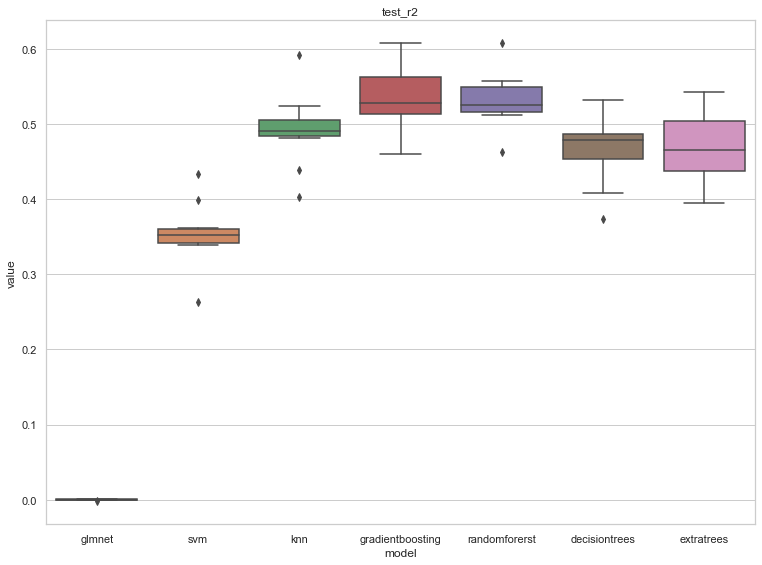

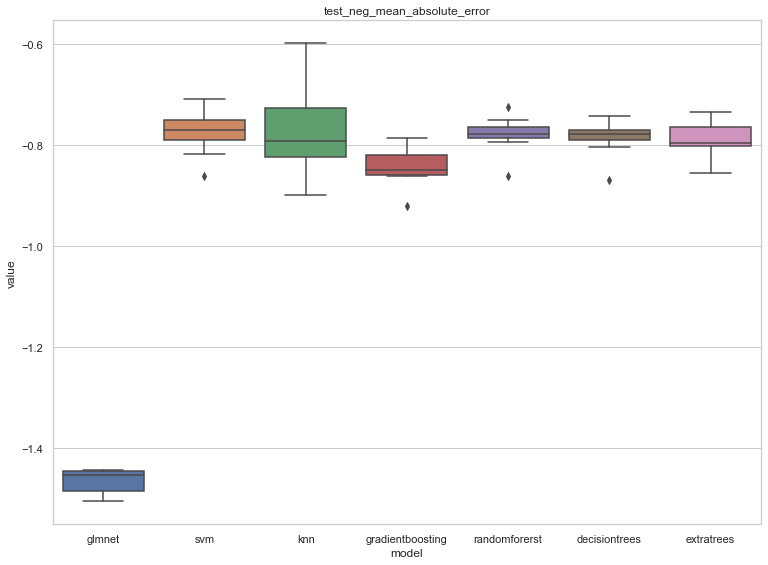

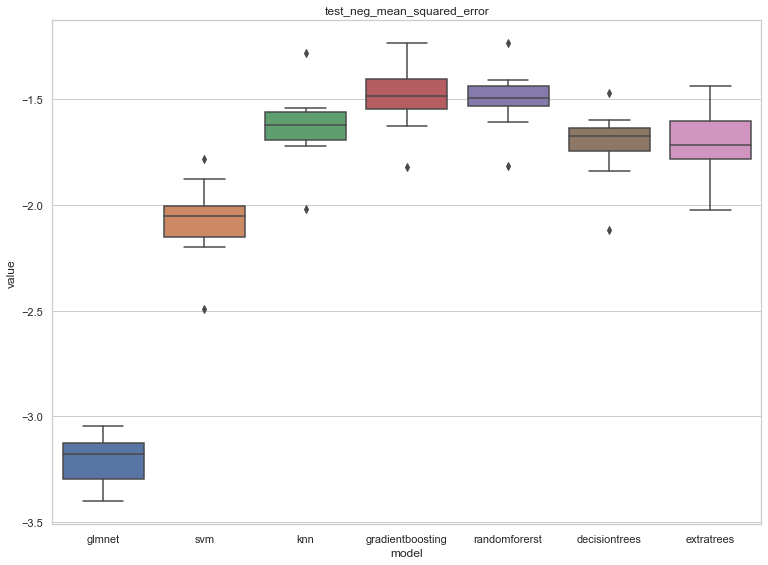

In [6]:

scores_galaxy = crossvalidate_pipeline_scores(
    X=X_train_galaxy,
    y=y_train_galaxy,
    pipelines=pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores_galaxy)


 # Feature selection

 * Doing a quick feature selection with RFECV using decision tree model
 * Only five columns are kept and these are same in both datasets

In [7]:

selector = RFECV(DecisionTreeRegressor(), step=1, cv=5)
selector_iphone = selector.fit(X_train_iphone, y_train_iphone)
selector_galaxy = selector.fit(X_train_galaxy, y_train_galaxy)

iphone_columns_to_keep = X_train_galaxy.columns[selector_iphone.support_]
galaxy_columns_to_keep = X_train_galaxy.columns[selector_galaxy.support_]

X_train_iphone_rfecv = X_train_iphone[iphone_columns_to_keep].copy()
X_test_iphone_rfecv = X_test_iphone[iphone_columns_to_keep].copy()
X_train_galaxy_rfecv = X_train_galaxy[galaxy_columns_to_keep].copy()
X_test_galaxy_rfecv = X_test_galaxy[galaxy_columns_to_keep].copy()

print("Columns to keep in the iphone dataset:", X_train_iphone_rfecv.columns)
print("Columns to keep in the galaxy dataset:", X_train_galaxy_rfecv.columns)


Columns to keep in the iphone dataset: Index(['iphone', 'samsunggalaxy', 'htcphone', 'htccampos', 'iphonedispos'], dtype='object')
Columns to keep in the galaxy dataset: Index(['iphone', 'samsunggalaxy', 'htcphone', 'htccampos', 'iphonedispos'], dtype='object')


 # Model Performance After Feature Selection with IPhone Data

 * Models perform bit worse with the feature selection except for SVM
 * GLMNET still performs poorly and other models are roughly comparable

Crossvalidating glmnet
Crossvalidating svm
Crossvalidating knn
Crossvalidating gradientboosting
Crossvalidating randomforerst
Crossvalidating decisiontrees
Crossvalidating extratrees
test_r2
test_neg_mean_absolute_error
test_neg_mean_squared_error


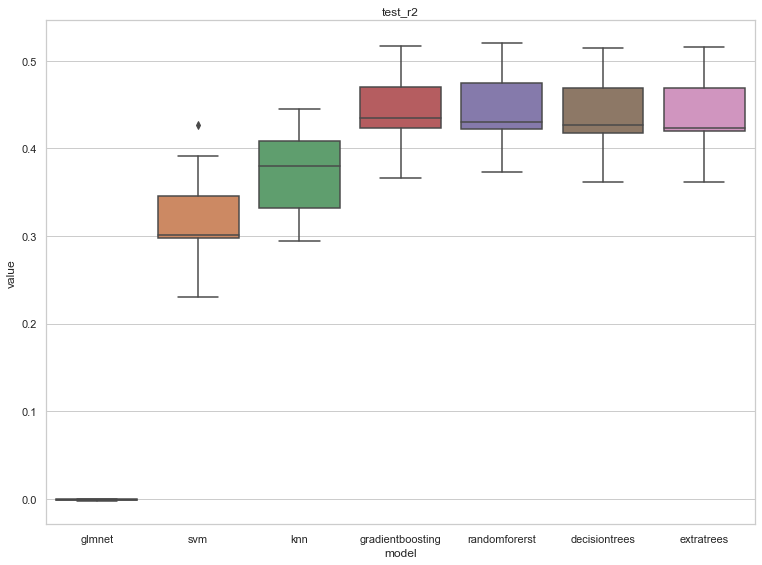

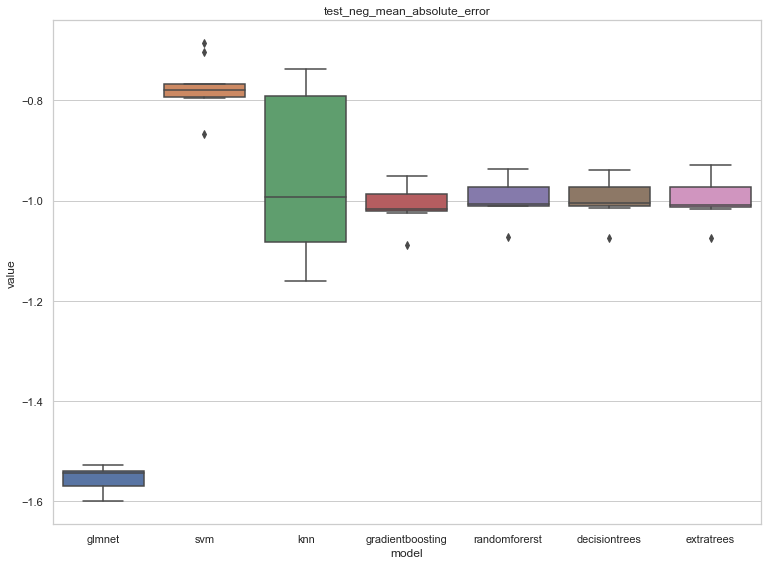

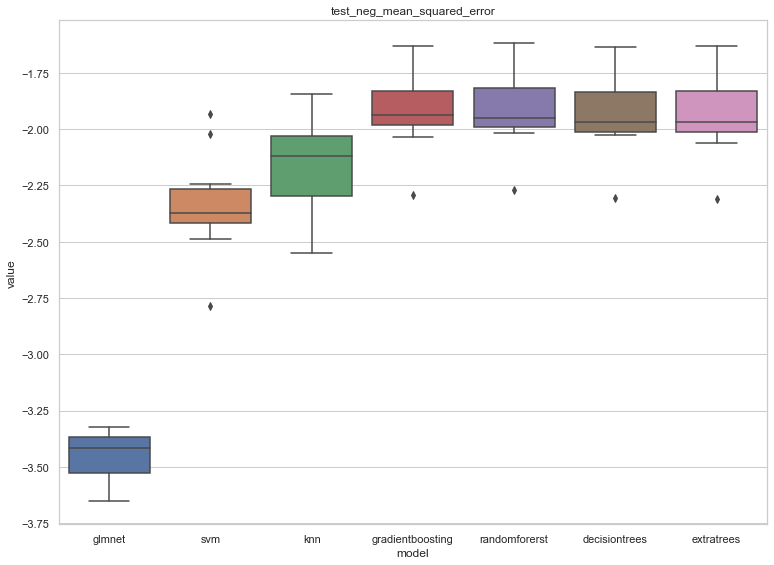

In [8]:

scores_iphone = crossvalidate_pipeline_scores(
    X=X_train_iphone_rfecv,
    y=y_train_iphone,
    pipelines=pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores_iphone)


 # Model Performance After Feature Selection with Galaxy Data

 * Models perform bit worse with the feature selection except for SVM
 * GLMNET still performs poorly and other models are roughly comparable

Crossvalidating glmnet
Crossvalidating svm
Crossvalidating knn
Crossvalidating gradientboosting
Crossvalidating randomforerst
Crossvalidating decisiontrees
Crossvalidating extratrees
test_r2
test_neg_mean_absolute_error
test_neg_mean_squared_error


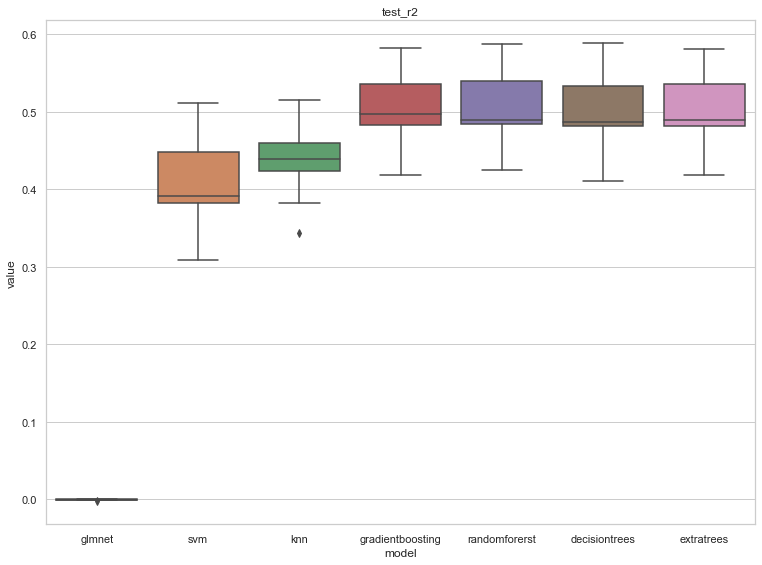

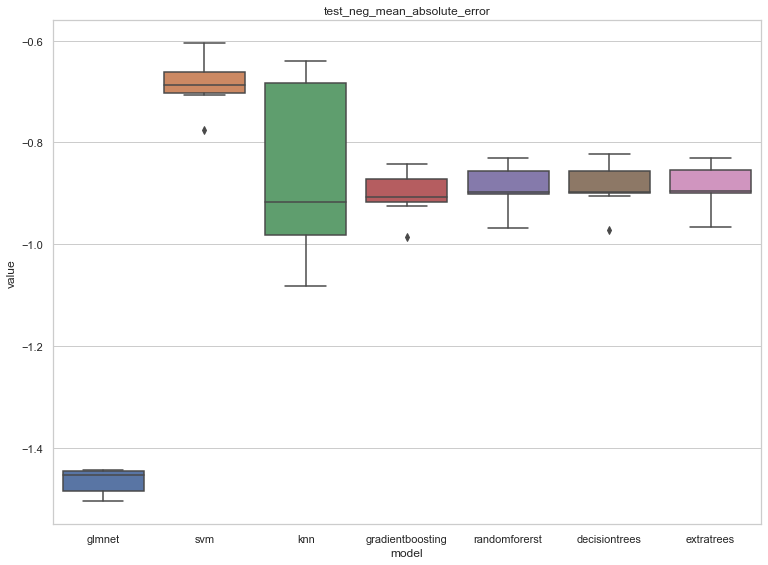

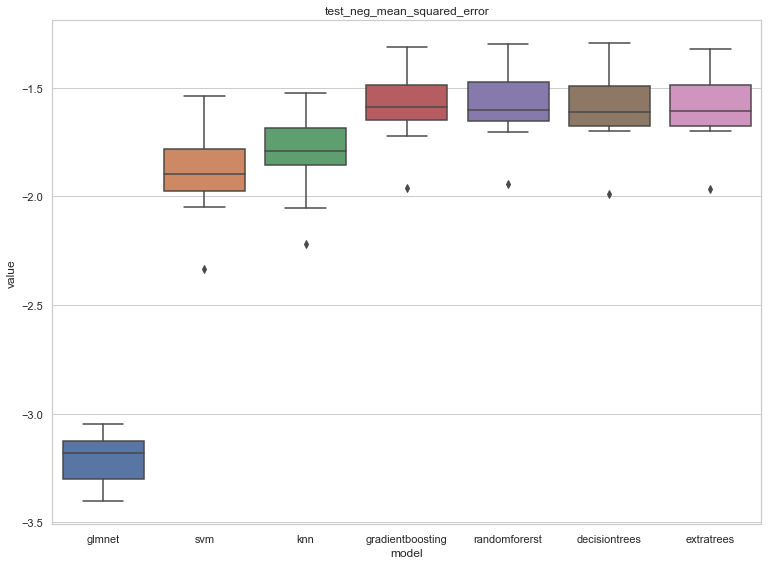

In [9]:

scores_galaxy = crossvalidate_pipeline_scores(
    X=X_train_galaxy_rfecv,
    y=y_train_galaxy,
    pipelines=pipelines,
    n_splits=10,
    random_state=random_state,
)

plot_scores(scores=scores_galaxy)


 # Conclusion

 * GLMNET performs so poorly that we will not take it into futher consideration
 * Training SVM takes too long and does not offer many benefits over other models
 * With the tree models Random forest is bit better than Decision Trees and Extra Trees,
 so we drop the formers out

 * Models picked for further analysis:
   * KNN
   * Gradient Boosting
   * Random Forest